In [ ]:
# Install YOLOv8 from Ultralytics
!pip install ultralytics


In [ ]:
import os
import json
import pandas as pd

In [ ]:
det = 'https://bj.bcebos.com/paddlex/examples/meter_reader/datasets/meter_det.tar.gz'

if ('meter_seg' not in os.listdir()):
    for i in [det]:
        !wget $i
        dir_name = i.split('/')[-1]
        !tar -xf $dir_name
else:
    print('Directory already exist')

In [ ]:
import os
import json
import pandas as pd

# Define class mapping (update if you have multiple classes)
class_map = {'meter': 0}

# Function to convert bbox to YOLO format
def convert_bbox_to_yolo(bbox, img_width, img_height):
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return [x_center, y_center, width, height]

# Process annotations for train/test datasets
for name in ['test', 'train']:
    with open(f'meter_det/annotations/instance_{name}.json') as file:
        annotations = json.load(file)

    images = annotations['images']
    annotation = annotations['annotations']

    # Create mapping for image metadata
    img_datas = {i['id']: [i['file_name'], i['width'], i['height']] for i in images}

    # Group bbox annotations by image
    bboxs = {}
    for i in annotation:
        img_id = i['image_id']
        if img_id not in bboxs:
            bboxs[img_id] = [i['bbox']]
        else:
            bboxs[img_id].append(i['bbox'])

    # Generate YOLO-format labels
    for img_id, bboxes in bboxs.items():
        file_name, width, height = img_datas[img_id]
        txt_file_path = f"meter_det/{name}/labels/{os.path.splitext(file_name)[0]}.txt"

        os.makedirs(os.path.dirname(txt_file_path), exist_ok=True)
        with open(txt_file_path, 'w') as label_file:
            for bbox in bboxes:
                yolo_bbox = convert_bbox_to_yolo(bbox, width, height)
                label_file.write(f"{class_map['meter']} " + " ".join(map(str, yolo_bbox)) + "\n")

    print(f"Processed {name} dataset.")


In [ ]:
!yolo task=detect mode=train model=best.pt data=data.yaml epochs=50 imgsz=640

In [ ]:
import os

# Define paths
images_dir = 'meter_det/train/images'  # Update with your images path
labels_dir = 'meter_det/train/labels'  # Update with your labels path

# Validate labels
for image_file in os.listdir(images_dir):
    image_name, _ = os.path.splitext(image_file)
    label_file = f"{image_name}.txt"
    label_path = os.path.join(labels_dir, label_file)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                print(f"Empty label file: {label_path}")
            else:
                print(f"Valid labels found for {image_file}")
    else:
        print(f"Missing label file for {image_file}")

## OCR Confi && yolo

In [ ]:

import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
model = YOLO("Models/model_1_0_2.pt")
reader = easyocr.Reader(['en'])

from typing import Dict, Any
def detect_and_recognize(image_path: str) -> Dict[str, Dict[str, Any]]:
    results = model.predict(source=image_path, conf=0.15, save=False)
    output = {}
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
            # Extract detection info
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
            class_id = int(box.cls)
            class_name = result.names[class_id]
            yolo_conf = box.conf.item()

            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(image_rgb, f"{class_name} {yolo_conf:.2f}",
                        (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            # Process image region
            image = cv2.imread(image_path)
            cropped = image[y_min:y_max, x_min:x_max]
            ocr_results = reader.readtext(cropped)
            ocr_boxes = [detection[0] for detection in ocr_results]
            # _, text, conf = box
            print(result.names[class_id] , box.conf)
            # Print OCR confidence for each detected text
            for detection in ocr_results:
                ocr_text = detection[1]
                ocr_confidence = detection[2]
                print(f"OCR Text: {ocr_text}, Confidence: {ocr_confidence}")


detect_and_recognize('testimg/images/23.jpeg')


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
import matplotlib.pyplot as plt

# Load YOLOv8 model and EasyOCR reader
model = YOLO("Models/model_1_0_2.pt")
reader = easyocr.Reader(['en'])

from typing import Dict, Any

def detect_and_recognize(image_path: str) -> Dict[str, Dict[str, Any]]:
    results = model.predict(source=image_path, conf=0.15, save=False)
    output = {}

    # Load the image to draw bounding boxes
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying with Matplotlib

    for result in results:
        for box in result.boxes:
            # Extract detection info
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])
            class_id = int(box.cls)
            class_name = result.names[class_id]
            yolo_conf = box.conf.item()  # YOLO confidence

            # Process image region for OCR
            cropped = image[y_min:y_max, x_min:x_max]
            ocr_results = reader.readtext(cropped)
            
            # Draw bounding box on the image
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
            cv2.putText(image_rgb, f"{class_name} {yolo_conf:.2f}",
                        (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Print YOLO class and confidence
            print(f"YOLO Class: {class_name}, YOLO Confidence: {yolo_conf:.2f}")

            # Process OCR results for each bounding box
            for detection in ocr_results:
                ocr_text = detection[1]
                ocr_confidence = detection[2]
                # Print OCR text and confidence
                print(f"OCR Text: {ocr_text}, OCR Confidence: {ocr_confidence:.2f}")

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axes
    plt.show()

    return output

# Test the function
detect_and_recognize('testimg/images/1.png')


## Custom OCR Model 

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  
model.train(data='data.yaml', epochs=50, imgsz=640)


In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load your trained YOLOv8 model
model = YOLO("Models/ocr-best.pt")

def detect_and_sort_digits(image_path, show_bboxes=True, gap_multiplier=1.5):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image)

    # Extract bounding boxes
    bboxes = []
    boxes = results[0].boxes
    for box, conf, cls in zip(boxes.xyxy, boxes.conf, boxes.cls):
        x_min = int(box[0].item())
        y_min = int(box[1].item())
        x_max = int(box[2].item())
        y_max = int(box[3].item())
        confidence = float(conf.item())
        class_id = int(cls.item())
        if class_id != 10:  # Assuming class 10 is dot ('.')
            bboxes.append([x_min, y_min, x_max, y_max, confidence, class_id])

    # Print the class labels (IDs) and bounding boxes
    print("Detected Bboxes with Class IDs and Confidence:")
    for bbox in bboxes:
        print(f"Class ID: {bbox[5]}, Bbox: {bbox[:4]}, Confidence: {bbox[4]:.2f}")
    
    if show_bboxes:
        for bbox in bboxes:
            x_min, y_min, x_max, y_max, conf, label = bbox
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image_rgb, 
                        f"{label} ({conf:.2f})",
                        (x_min, y_min - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.7, 
                        (0, 255, 0), 
                        2)

        plt.figure(figsize=(10, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()

    digit_sequence = sort_and_extract_digits(bboxes, gap_multiplier)
    
    return digit_sequence

def sort_and_extract_digits(bboxes, gap_multiplier=1.5):
    if not bboxes:
        return ""
    
    # Sort by horizontal position
    sorted_bboxes = sorted(bboxes, key=lambda b: (b[0] + b[2])/2)
    avg_width = sum(b[2]-b[0] for b in sorted_bboxes)/len(sorted_bboxes)
    gap_threshold = avg_width * gap_multiplier
    
    # Group digits based on x-axis gaps
    groups = []
    current_group = [sorted_bboxes[0]]
    
    for bbox in sorted_bboxes[1:]:
        last_bbox = current_group[-1]
        gap = bbox[0] - last_bbox[2] 
        
        if gap > gap_threshold:
            groups.append(current_group)
            current_group = [bbox]
        else:
            current_group.append(bbox)
    
    groups.append(current_group)  
    return " ".join(["".join(str(b[5]) for b in group) for group in groups])

# Test with an example
image_path = 'testimg/ok/7.jpg'
result = detect_and_sort_digits(image_path, gap_multiplier=1.5)
print(f"Formatted Number: {result}")


## test images

In [ ]:
from ultralytics import YOLO
# Load trained model
model = YOLO("Models/2classmodel.pt")

# Perform detection
results = model("testimg/Analog/1 (1).jpeg", conf=0.2)

# Visualize results
for r in results:
    print(r.obb)
print(results[0].show())



image 1/1 c:\Users\soura\Downloads\ML-Model\testimg\Analog\1 (1).jpeg: 480x640 124.4ms
Speed: 6.4ms preprocess, 124.4ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)
ultralytics.engine.results.OBB object with attributes:

cls: tensor([1., 1., 1., 1., 1., 1., 1., 0.])
conf: tensor([0.9831, 0.9824, 0.9793, 0.9740, 0.9708, 0.9678, 0.9615, 0.8770])
data: tensor([[8.1210e+02, 3.8451e+02, 7.5835e+01, 7.1717e+01, 1.7422e-03, 9.8309e-01, 1.0000e+00],
        [1.0396e+03, 4.8656e+02, 6.7314e+01, 6.6687e+01, 3.1410e+00, 9.8235e-01, 1.0000e+00],
        [9.3450e+02, 4.2621e+02, 7.0389e+01, 6.6717e+01, 1.2177e-02, 9.7931e-01, 1.0000e+00],
        [4.3761e+02, 4.1382e+02, 6.1542e+01, 6.1196e+01, 1.0011e-02, 9.7400e-01, 1.0000e+00],
        [5.6243e+02, 3.7949e+02, 6.4825e+01, 6.2869e+01, 9.4554e-04, 9.7077e-01, 1.0000e+00],
        [6.9257e+02, 3.7082e+02, 7.0380e+01, 6.5683e+01, 3.1406e+00, 9.6784e-01, 1.0000e+00],
        [3.3039e+02, 4.6609e+02, 6.1835e+01, 5.9275e+01, 3.0064

testimg/Analog/1 (1).jpeg


image 1/1 c:\Users\soura\Downloads\ML-Model\ed\images\1 (1).jpeg: 480x640 144.3ms
Speed: 16.1ms preprocess, 144.3ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


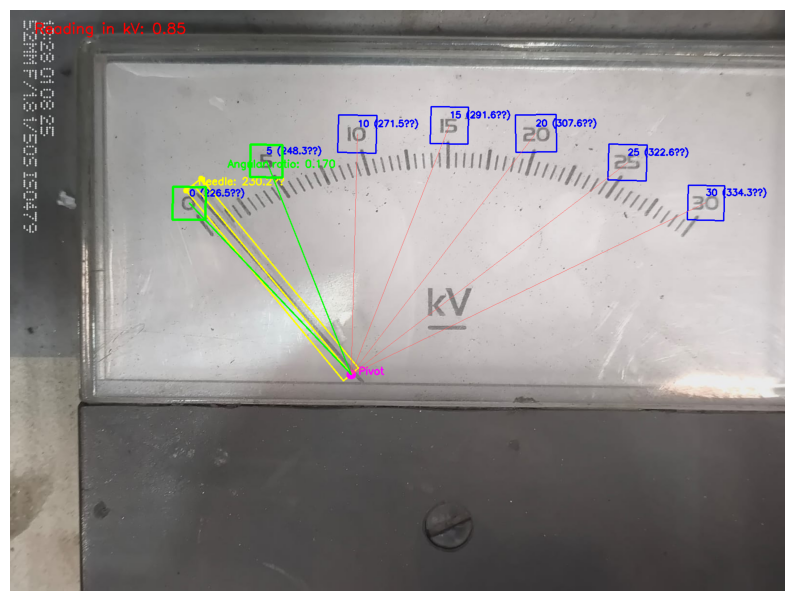

Meter reading in kV: 0.85


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO("Models/best.pt")

def get_meter_reading(image_path, model):
    results = model(image_path, conf=0.2)
    obb_data = results[0].obb
    class_names = results[0].names

    if obb_data is None:
        return "No objects detected"

    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    number_positions = []
    needle_corners = None
    number_values = [0, 5, 10, 15, 20, 25, 30]
    
    # Extract corners for needle and numbers
    for i, class_id in enumerate(obb_data.cls.cpu().numpy()):
        class_name = class_names[int(class_id)]
        if hasattr(obb_data, "xyxyxyxy") and obb_data.xyxyxyxy is not None:
            corners_flat = obb_data.xyxyxyxy.cpu().numpy()[i]
            corners = np.array(corners_flat).reshape(4, 2)
            
            if class_name.lower() == "needle":
                needle_corners = corners
                # Draw bounding box for needle
                cv2.polylines(image, [corners.astype(np.int32)], isClosed=True, color=(0, 255, 255), thickness=2)
                
                # Show needle tip coordinates
                for j in [2, 3]:  # corners 3 and 4 (index 2 and 3)
                    corner = corners[j]
                    cv2.circle(image, (int(corner[0]), int(corner[1])), 6, (0, 255, 255), -1)
                    
            elif class_name.lower() == "numbers":
                # Calculate center point for sorting
                center_x = np.mean(corners[:, 0])
                center_y = np.mean(corners[:, 1])
                number_positions.append((corners, center_x, center_y))
                # Draw bounding box for number
                cv2.polylines(image, [corners.astype(np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)
    
    # Sort number positions from left to right
    number_positions.sort(key=lambda x: x[1])
    
    # Estimate meter center (pivot point of the needle)
    # For most analog meters, the pivot point is near the bottom center of the image
    # This is a critical improvement as it accounts for the circular motion of the needle
    meter_center_x = w // 2
    meter_center_y = int(h * 0.8)  # Assuming pivot is near bottom of image
    
    # Try to improve center estimation by analyzing needle position
    if needle_corners is not None:
        # Use the bottom center between corners 0 and 1 of the needle as pivot estimation
        bottom_center_x = (needle_corners[0][0] + needle_corners[1][0]) / 2
        bottom_center_y = (needle_corners[0][1] + needle_corners[1][1]) / 2
        meter_center_x = int(bottom_center_x)
        meter_center_y = int(bottom_center_y)
    
    # Draw estimated meter center
    cv2.circle(image, (meter_center_x, meter_center_y), 10, (255, 0, 255), -1)
    cv2.putText(image, "Pivot", (meter_center_x + 15, meter_center_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
    
    # Assign values and calculate angles from meter center
    labeled_numbers = []
    for i, (corners, center_x, center_y) in enumerate(number_positions):
        if i < len(number_values):
            value = number_values[i]
            
            # Calculate angle from meter center to number center
            dx = center_x - meter_center_x
            dy = center_y - meter_center_y
            angle = np.degrees(np.arctan2(dy, dx))
            # Adjust angle to 0-360 range
            if angle < 0:
                angle += 360
                
            labeled_numbers.append((corners, value, center_x, center_y, angle))
            
            # Draw line from center to number
            cv2.line(image, (meter_center_x, meter_center_y), (int(center_x), int(center_y)), 
                     (100, 100, 255), 1)
            
            # Add value and angle label
            cv2.putText(image, f"{value} ({angle:.1f}°)", (int(center_x), int(center_y) - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    # Sort labeled_numbers by angle for proper interpolation
    labeled_numbers.sort(key=lambda x: x[4])
    
    # Get needle angle and position
    interpolated_value = None
    if needle_corners is not None and labeled_numbers:
        # Calculate needle tip position (midpoint of corners 3 and 4)
        needle_tip_x = (needle_corners[2][0] + needle_corners[3][0]) / 2
        needle_tip_y = (needle_corners[2][1] + needle_corners[3][1]) / 2
        
        # Calculate needle angle from meter center to needle tip
        dx = needle_tip_x - meter_center_x
        dy = needle_tip_y - meter_center_y
        needle_angle = np.degrees(np.arctan2(dy, dx))
        # Adjust angle to 0-360 range
        if needle_angle < 0:
            needle_angle += 360
            
        # Draw needle line
        cv2.line(image, (meter_center_x, meter_center_y), 
                 (int(needle_tip_x), int(needle_tip_y)), (0, 255, 255), 2)
        cv2.putText(image, f"Needle: {needle_angle:.1f}°", (int(needle_tip_x) + 10, int(needle_tip_y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        # Find the two values that the needle angle is between
        left_value = None
        right_value = None
        left_angle = None
        right_angle = None
        
        for i, (corners, value, center_x, center_y, angle) in enumerate(labeled_numbers):
            if angle <= needle_angle:
                left_value = value
                left_angle = angle
                left_corners = corners
                left_center = (int(center_x), int(center_y))
            else:
                right_value = value
                right_angle = angle
                right_corners = corners
                right_center = (int(center_x), int(center_y))
                break
        
        # Special case: needle angle is beyond the last marker
        if left_value is None and right_value is not None:
            interpolated_value = right_value
            cv2.polylines(image, [right_corners.astype(np.int32)], isClosed=True, 
                          color=(0, 0, 255), thickness=3)
            
        # Special case: needle angle is before the first marker
        elif right_value is None and left_value is not None:
            interpolated_value = left_value
            cv2.polylines(image, [left_corners.astype(np.int32)], isClosed=True, 
                          color=(0, 0, 255), thickness=3)
            
        # If needle is between two values, use angular interpolation
        elif left_value is not None and right_value is not None:
            # Calculate angular ratio
            angle_range = right_angle - left_angle
            # Handle edge case where angles cross 0/360 boundary
            if angle_range < 0:
                angle_range += 360
                
            needle_angle_distance = needle_angle - left_angle
            if needle_angle_distance < 0:
                needle_angle_distance += 360
                
            if angle_range > 0:  # Avoid division by zero
                ratio = needle_angle_distance / angle_range
                
                # Interpolate between the two values
                value_range = right_value - left_value
                interpolated_value = left_value + (ratio * value_range)
                
                # Highlight both adjacent number boxes
                cv2.polylines(image, [left_corners.astype(np.int32)], isClosed=True, 
                              color=(0, 255, 0), thickness=3)
                cv2.polylines(image, [right_corners.astype(np.int32)], isClosed=True, 
                              color=(0, 255, 0), thickness=3)
                
                # Draw arc between the two adjacent values
                cv2.line(image, (meter_center_x, meter_center_y), left_center, (0, 255, 0), 2)
                cv2.line(image, (meter_center_x, meter_center_y), right_center, (0, 255, 0), 2)
                
                # Show interpolation information
                midpoint_x = int((left_center[0] + right_center[0]) / 2)
                midpoint_y = int((left_center[1] + right_center[1]) / 2) - 30
                cv2.putText(image, f"Angular ratio: {ratio:.3f}", (midpoint_x, midpoint_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    # Display result on image
    if interpolated_value is not None:
        # Round to 2 decimal places for higher precision display
        rounded_value = round(interpolated_value, 2)
        cv2.putText(image, f"Reading in kV: {rounded_value}", (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
        
    # Display the image with annotations
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    if interpolated_value is not None:
        return round(interpolated_value, 2)
    else:
        return "Needle position could not be determined"

image_path = "ed/images/1 (1).jpeg"
result = get_meter_reading(image_path, model)
print(f"Meter reading in kV: {result}")